## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation

In [5]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81', 'var_110', 'var_152', 'var_175', 'var_183', 'var_199']

<b> random split

In [8]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [9]:
train_dataset_scaled, scalerx = scaler(train_dataset)

In [10]:
train_dataset_scaled = train_dataset_scaled[ ['target'] + numerical_features]

means_train = np.mean(train_dataset_scaled[numerical_features])  ### Save this
cov_train = np.cov(train_dataset_scaled[numerical_features].T) ### Save this

In [11]:
train_dataset_scaled = compute_mahalanobis_parts(train_dataset_scaled, numerical_features, 20000,[True,True], means_train, cov_train )

<b> sectioning:

In [12]:
train_section_1 = train_dataset_scaled[train_dataset_scaled.mahalanobis > 15]
train_section_2 = train_dataset_scaled[(train_dataset_scaled.mahalanobis > 9) & (train_dataset_scaled.mahalanobis <= 15)]
train_section_3 = train_dataset_scaled[train_dataset_scaled.mahalanobis <= 9]

<b> augmentation:

In [13]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
Name: mahalanobis, dtype: int64

In [14]:
def augmentation_strategy(data, dict_1,dict_2, dict_3,gen_mean, gen_cov, columns_features ):
    aug_normal = normal_augmentation(data = data , columns = columns_features, n = dict_1['n'],
                          pop_mean = gen_mean, pop_cov = gen_cov, range_distance = dict_1['range'], label_target = dict_1['label'], rate = dict_1['rate'])
    
    aug_conditioned_1 = concentrated_augmentation(data = data, columns = columns_features, n = dict_2['n'], category = dict_2['label'])
    
    aug_conditioned_2 = concentrated_augmentation(data = aug_normal, columns = columns_features, n = dict_3['n'], category = dict_3['category'], label_target = dict_3['label'])
    
    augmentation_result = pd.concat([data, aug_normal,  aug_conditioned_1, aug_conditioned_2])
    
    return augmentation_result 

In [15]:
dict_1 = {'n':1600, 'range': [15,35], 'label': 2, 'rate': 0.65}
dict_2 = {'n':1800, 'label': 1}
dict_3 = {'n':800, 'range': [15,35], 'label': 4, 'category': 2}

train_section_1_aug = augmentation_strategy(data = train_section_1, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features )

In [16]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
2     1600
3     1800
4      800
Name: mahalanobis, dtype: int64

### Model Exploration

In [17]:
def augmentation_selection_rates(data, rate = 0.0, sample = 1.0):
    data1 = data[data.target.isin([0,1])].copy()
    data2 = data[~data.target.isin([0,1])].sample(frac = rate).copy()
    data2['target'] = 1
    
    dataresult = pd.concat([data1,data2]).sample(frac = sample).copy()
    return dataresult

### Common data to train and validation

In [18]:
seed = 158
validation_dataset_section1 = train_section_1_aug[train_section_1_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section1 = validation_dataset_section1.copy()
train_dataset_section1 = train_section_1_aug[~train_section_1_aug.index.isin(validation_dataset_section1.index)]

In [19]:
train_dataset_section1_aug = augmentation_selection_rates(train_dataset_section1, rate = 1.0, sample = 0.7)

In [20]:
X_train = train_dataset_section1_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section1_aug['target']

X_val = validation_dataset_section1[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section1['target']

In [21]:
def metrics_train_validation(model, X_train, Y_train, X_val, Y_val):
    predictions_train, predictions_probas = model.predict(X_train), model.predict_proba(X_train)[:,1]
    
    metrics = {'Train' : {'precision': precision_score(Y_train.values,predictions_train),
          'Accuracy' : accuracy_score(Y_train.values,predictions_train),
          'AUC' : roc_auc_score(Y_train.values,predictions_probas)}}

    predictions_validation, predictions_probas = model.predict(X_val),  model.predict_proba(X_val)[:,1]

    metrics['Validation'] = {'precision': precision_score(Y_val.values,predictions_validation),
              'Accuracy' : accuracy_score(Y_val.values,predictions_validation),
              'AUC' : roc_auc_score(Y_val.values,predictions_probas)}

    to_conf_mat = pd.DataFrame({'True': Y_val, 'Pred' : predictions_validation})
    conf_mat = to_conf_mat.assign(ones = 1).pivot_table(index = 'True', columns = 'Pred',values = 'ones', aggfunc = 'count')
    
    return metrics, conf_mat, predictions_validation

#### Support Vector Machine

In [29]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.35, probability = True)
my_svm.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.35, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [32]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [33]:
svm_metrics

{'Train': {'precision': 0.9997565725413826,
  'Accuracy': 0.9895373973194985,
  'AUC': 0.9999801403881122},
 'Validation': {'precision': 0.759493670886076,
  'Accuracy': 0.872104247104247,
  'AUC': 0.7251996408135989}}

In [34]:
conf_mat

Pred,0,1
True,,
0,3374,76
1,454,240


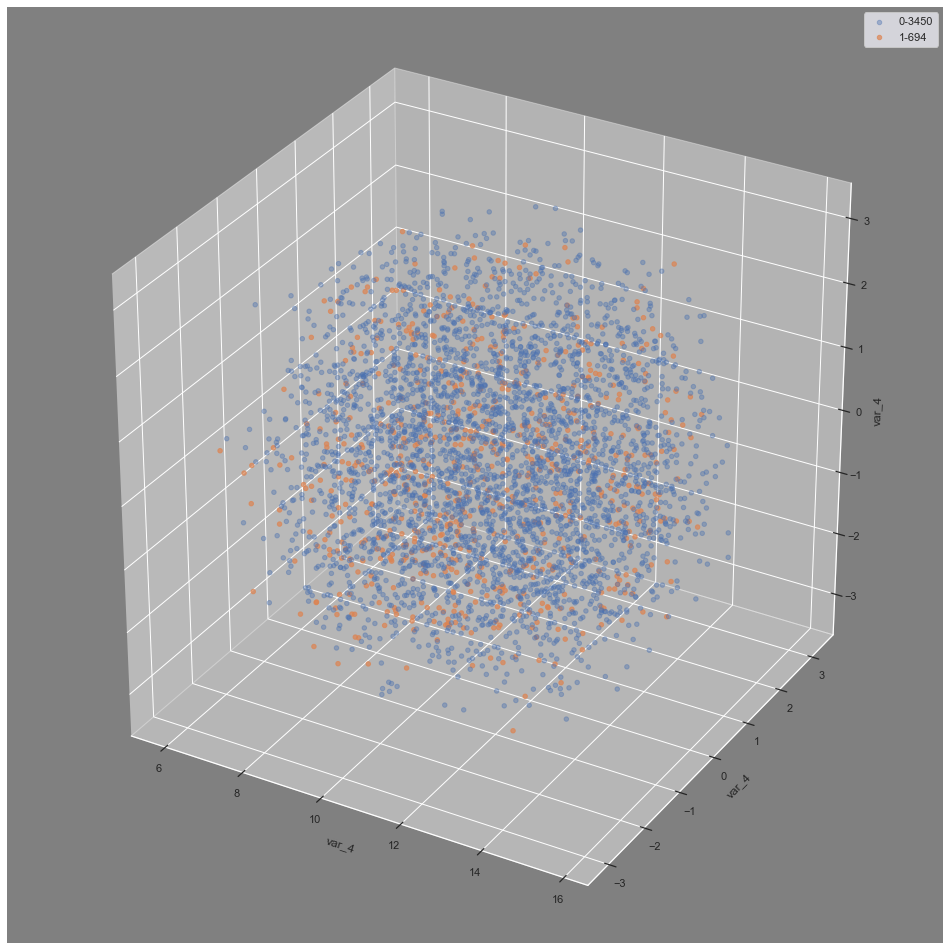

In [35]:
threeD_plot(validation_dataset_section1,['var_4', 'var_12', 'var_46'], fraq = 1.00)

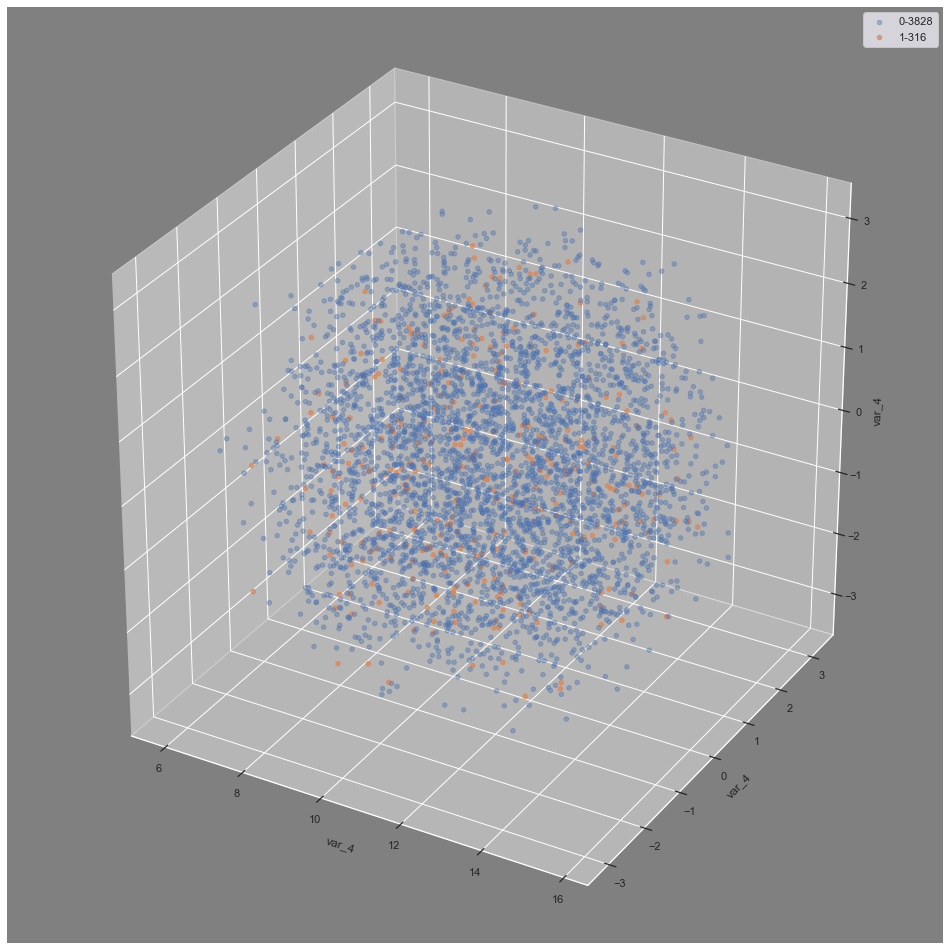

In [36]:
validation_set_pred = validation_dataset_section1.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

### KNN

In [37]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [38]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [40]:
knn_metrics

{'Train': {'precision': 0.86783988957902,
  'Accuracy': 0.8188499783830523,
  'AUC': 0.9078206119945736},
 'Validation': {'precision': 0.2803030303030303,
  'Accuracy': 0.7765444015444015,
  'AUC': 0.6338219939021843}}

In [41]:
conf_mat

Pred,0,1
True,,
0,3070,380
1,546,148


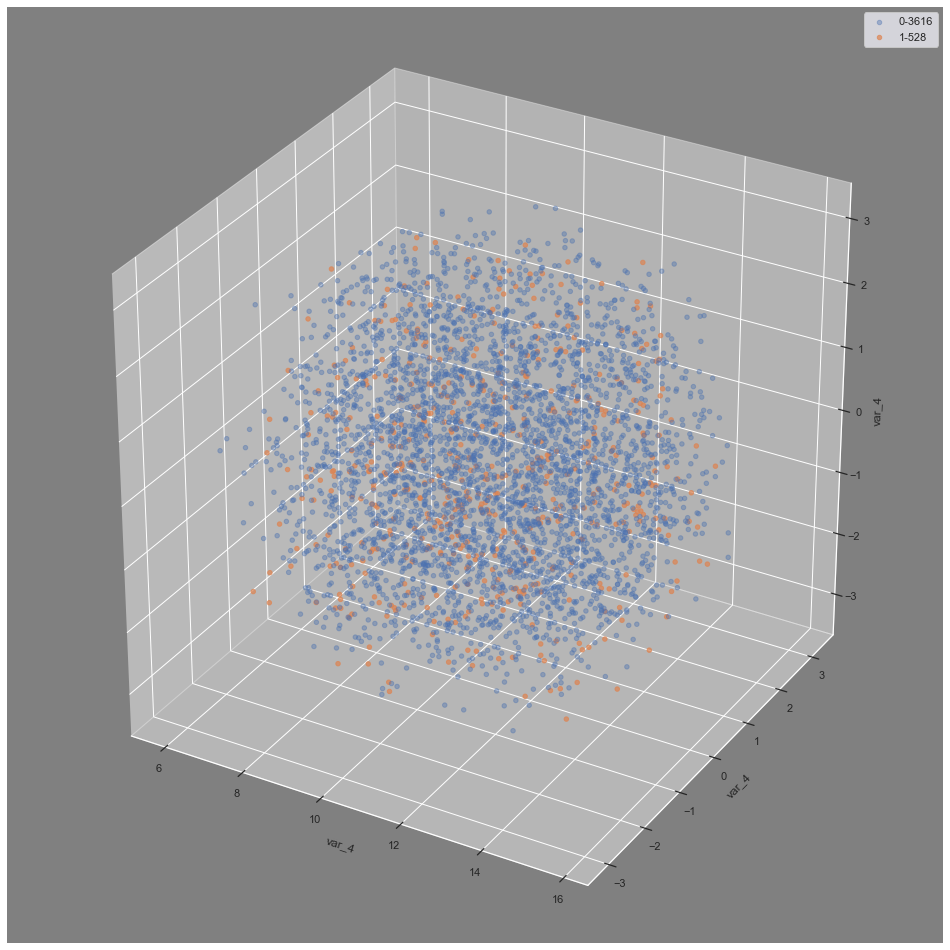

In [42]:
validation_set_pred = validation_dataset_section1.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

### Random Forest

In [43]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [45]:
rf_metrics

{'Train': {'precision': 0.9515254237288135,
  'Accuracy': 0.8648508430609598,
  'AUC': 0.9723867571723342},
 'Validation': {'precision': 0.46511627906976744,
  'Accuracy': 0.82746138996139,
  'AUC': 0.712941151902435}}

In [46]:
conf_mat

Pred,0,1
True,,
0,3289,161
1,554,140


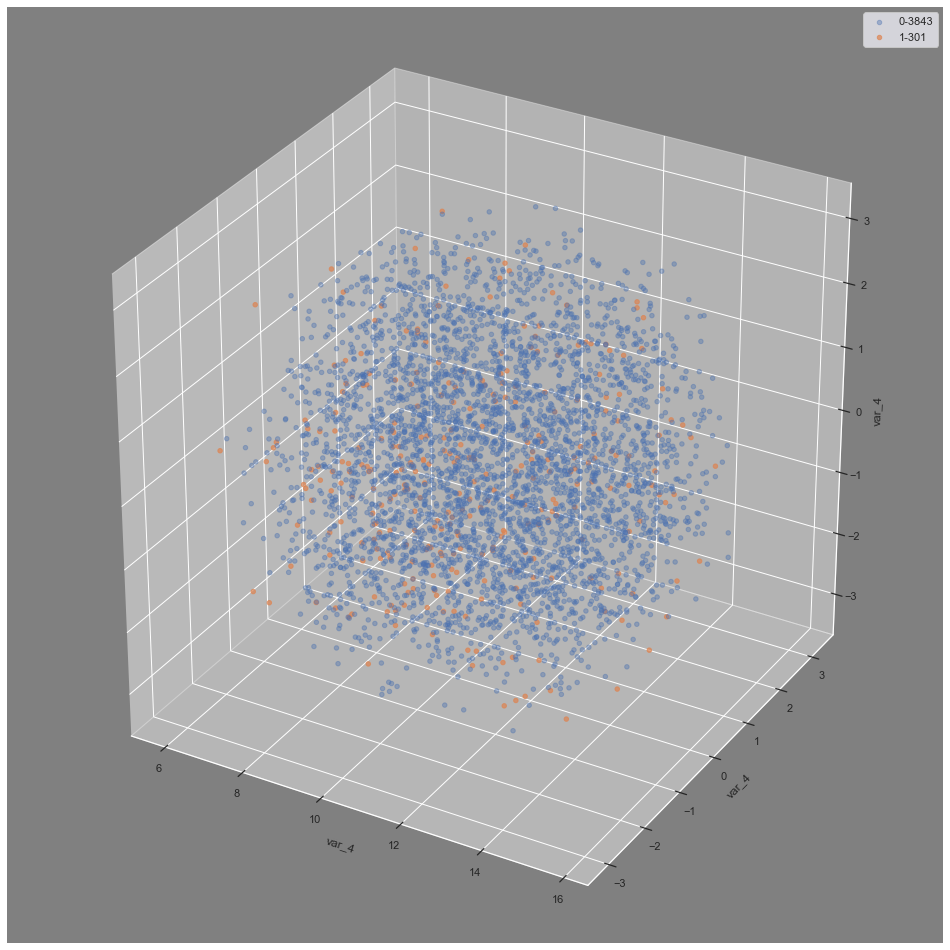

In [47]:
validation_set_pred = validation_dataset_section1.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

<b> Summary

In [63]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.759494,0.872104,0.725200
KNN,0.280303,0.776544,0.633822
RF,0.465116,0.827461,0.712941


## Section 2

In [23]:
train_section_2.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    59759
1     7223
Name: mahalanobis, dtype: int64

In [24]:
dict_1 = {'n':4600, 'range': [15,35], 'label': 2, 'rate': 0.65}
dict_2 = {'n':4800, 'label': 1}
dict_3 = {'n':3800, 'range': [15,35], 'label': 4, 'category': 2}

train_section_2_aug = augmentation_strategy(data = train_section_2, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features )

In [25]:
train_section_2_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    59759
1     7223
2     4600
3     4800
4     3800
Name: mahalanobis, dtype: int64

### Common data to train and validation

In [26]:
seed = 158
validation_dataset_section2 = train_section_2_aug[train_section_2_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section2 = validation_dataset_section2.copy()
train_dataset_section2 = train_section_2_aug[~train_section_2_aug.index.isin(validation_dataset_section2.index)]

In [27]:
train_dataset_section2_aug = augmentation_selection_rates(train_dataset_section2, rate = 1.0, sample = 0.5)

In [28]:
len(train_dataset_section2_aug)

30953

In [73]:
X_train = train_dataset_section2_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section2_aug['target']

X_val = validation_dataset_section2[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section2['target']

#### Support Vector Machine

In [29]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.35, probability = True)
my_svm.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.35, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [30]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [31]:
svm_metrics

{'Train': {'precision': 1.0,
  'Accuracy': 0.9918720276696931,
  'AUC': 0.9999975502792294},
 'Validation': {'precision': 0.7822349570200573,
  'Accuracy': 0.8800675675675675,
  'AUC': 0.7328480140333291}}

In [32]:
conf_mat

Pred,0,1
True,,
0,3374,76
1,421,273


### KNN

In [33]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [34]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [35]:
knn_metrics

{'Train': {'precision': 0.8749126484975541,
  'Accuracy': 0.8198875918720276,
  'AUC': 0.9075832202378911},
 'Validation': {'precision': 0.27586206896551724,
  'Accuracy': 0.7760617760617761,
  'AUC': 0.632255565300923}}

In [36]:
conf_mat

Pred,0,1
True,,
0,3072,378
1,550,144


### Random Forest

In [37]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [39]:
rf_metrics

{'Train': {'precision': 0.9556918882072256,
  'Accuracy': 0.8655425853869434,
  'AUC': 0.9711369708506437},
 'Validation': {'precision': 0.45426829268292684,
  'Accuracy': 0.8252895752895753,
  'AUC': 0.7204147349956146}}

In [40]:
conf_mat

Pred,0,1
True,,
0,3271,179
1,545,149


<b> Summary

In [41]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.782235,0.880068,0.732848
KNN,0.275862,0.776062,0.632256
RF,0.454268,0.825290,0.720415


## Section 3

In [54]:
train_section_3.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    61175
1     5267
Name: mahalanobis, dtype: int64

In [55]:
dict_1 = {'n':4600, 'range': [15,35], 'label': 2, 'rate': 0.65}
dict_2 = {'n':4800, 'label': 1}
dict_3 = {'n':3800, 'range': [15,35], 'label': 4, 'category': 2}

train_section_3_aug = augmentation_strategy(data = train_section_3, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features )

In [56]:
train_section_3_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    61175
1     5267
2     4600
3     4800
4     3800
Name: mahalanobis, dtype: int64

### Common data to train and validation

In [57]:
seed = 158
validation_dataset_section3 = train_section_3_aug[train_section_3_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section3 = validation_dataset_section3.copy()
train_dataset_section3 = train_section_3_aug[~train_section_3_aug.index.isin(validation_dataset_section3.index)]

In [58]:
train_dataset_section3_aug = augmentation_selection_rates(train_dataset_section3, rate = 1.0, sample = 0.45)

In [59]:
len(train_dataset_section3_aug)

27689

In [60]:
X_train = train_dataset_section3_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section3_aug['target']

X_val = validation_dataset_section3[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section3['target']

#### Support Vector Machine

In [61]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.40, probability = True)
my_svm.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.4, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [62]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [63]:
svm_metrics

{'Train': {'precision': 1.0,
  'Accuracy': 0.8923760338040377,
  'AUC': 0.9950810478231684},
 'Validation': {'precision': 0.6153846153846154,
  'Accuracy': 0.9201685731487056,
  'AUC': 0.6586751000511564}}

In [64]:
conf_mat

Pred,0,1
True,,
0,15236,30
1,1296,48


### KNN

In [65]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [66]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [67]:
knn_metrics

{'Train': {'precision': 0.9468888888888889,
  'Accuracy': 0.8897034923615876,
  'AUC': 0.9504910776393751},
 'Validation': {'precision': 0.1586452762923351,
  'Accuracy': 0.8960264900662251,
  'AUC': 0.6233513589177319}}

In [68]:
conf_mat

Pred,0,1
True,,
0,14794,472
1,1255,89


### Random Forest

In [69]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [70]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [71]:
rf_metrics

{'Train': {'precision': 1.0,
  'Accuracy': 0.8739210516811731,
  'AUC': 0.983519040504084},
 'Validation': {'precision': 1.0,
  'Accuracy': 0.919626730885009,
  'AUC': 0.6786957614337494}}

In [72]:
conf_mat

Pred,0,1
True,,
0,15266.0,NaN
1,1335.0,9.0


<b> Summary

In [73]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.615385,0.920169,0.658675
KNN,0.158645,0.896026,0.623351
RF,1.000000,0.919627,0.678696


### Conclusions

* Limited or few number of variables improve computing power
* the data is splited in 3 parts thus attacking from less to most complex
* the tested models were SVM, KNN and RandomForest
* keep RF and SVM

* Section One:
    + fast execution time in general
    + it can be used the 100% of the data
* Section two:
    + fast execution time using some rate of the data
* section three:
    + low execution time , use high rate of the data or reduce dimmensionality
